<a href="https://colab.research.google.com/github/jenferon/Machine_Learning_Practise/blob/main/initial_notebooks_2_practise/tensorflow_testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/tlmakinen/deep21.git

Cloning into 'deep21'...
remote: Enumerating objects: 479, done.
remote: Counting objects: 100% (58/58), done.
remote: Compressing objects: 100% (49/49), done.
remote: Total 479 (delta 32), reused 20 (delta 9), pack-reused 421 (from 1)
Receiving objects: 100% (479/479), 33.53 MiB | 13.89 MiB/s, done.
Resolving deltas: 100% (297/297), done.


Testing out tensor flow and building a UNet


In [ ]:
cd deep21


/content/deep21


In [ ]:
# import the required Libraries
from __future__ import absolute_import, division, print_function
import numpy as np
import tensorflow as tf
from tensorflow import keras
import os

print(tf.__version__)


2.18.0


In [ ]:
# plot settings
import matplotlib

matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': False,
    'pgf.rcfonts': False,
})

import matplotlib.pyplot as plt

import seaborn as sns; sns.set()
%matplotlib inline

In [ ]:
!wget https://zenodo.org/record/4133772/files/cosmo-single.npy
!wget https://zenodo.org/record/4133772/files/obs-single.npy

--2025-04-09 14:07:11--  https://zenodo.org/record/4133772/files/cosmo-single.npy
Resolving zenodo.org (zenodo.org)... 188.185.48.194, 188.185.43.25, 188.185.45.92, ...
Connecting to zenodo.org (zenodo.org)|188.185.48.194|:443... connected.
HTTP request sent, awaiting response... 301 MOVED PERMANENTLY
Location: /records/4133772/files/cosmo-single.npy [following]
--2025-04-09 14:07:11--  https://zenodo.org/records/4133772/files/cosmo-single.npy
Reusing existing connection to zenodo.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 402653312 (384M) [application/octet-stream]
Saving to: ‘cosmo-single.npy’

cosmo-single.npy    100%[===================>] 384.00M  3.41MB/s    in 5m 47s  

2025-04-09 14:12:58 (1.11 MB/s) - ‘cosmo-single.npy’ saved [402653312/402653312]

--2025-04-09 14:12:58--  https://zenodo.org/record/4133772/files/obs-single.npy
Resolving zenodo.org (zenodo.org)... 188.185.45.92, 188.185.43.25, 188.185.48.194, ...
Connecting to zenodo.org (zenodo.org)|188.185

[ 65535 131071 196607 ... 589824 655360 720896]
(192, 64, 64, 64)


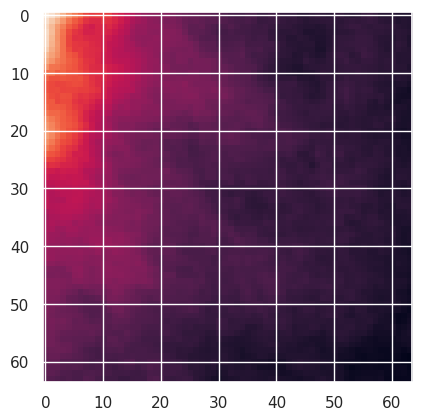

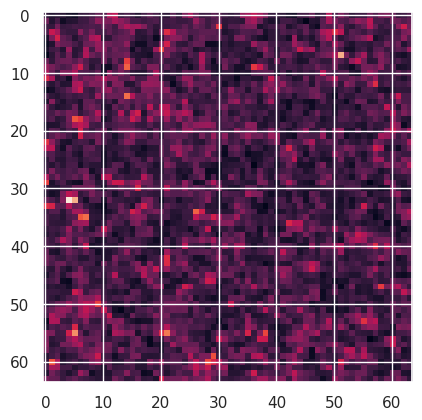

In [ ]:
index_arr = np.load('sim_info/rearr_nside4.npy')
print(index_arr)
# read in the observed and cosmological maps -- change to `cosmo-single.npy`
# if using smaller dataset
cosmo = np.load('cosmo-single.npy')
obs_map = np.load('obs-single.npy')
print(obs_map.shape)

plt.imshow(obs_map[0,:,:,0])
plt.show()
plt.imshow(cosmo[0,:,:,0])

In [ ]:
index_arr = np.load('sim_info/rearr_nside4.npy')
# ACTUAL FREQUENCY MEASUREMENTS
nutable = 'sim_info/' + "nuTable.txt"
(bn,nu_bot,nu_top,z_bot,z_top) = np.loadtxt(nutable).T
nu_arr = ((nu_bot + nu_top)/2.)[:-1]
print(len(nu_arr))

690


In [ ]:
pip install healpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 102.9 MB/s eta 0:00:00


Preprocess with FastICA

we have 192 voxels per sky simulation
we're working with 1 sky simulations
working in frequency range  350.33568 -- 492.10404  MHz
I put the PCA-3 subtraction put back into this shape :  (192, 64, 64, 64)


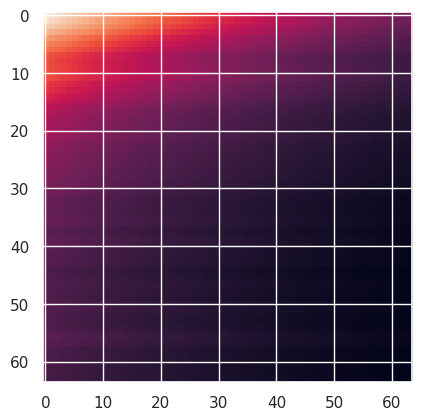

/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the ma

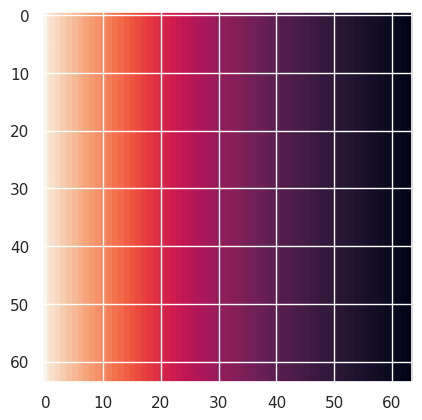

In [ ]:
from sklearn.decomposition import FastICA
import healpy as hp

def gen_rearr(nside):
    # recursive funtion for finding the right
    # ordering for the nested pixels
    if (nside==1):
        return np.array([0,1,2,3])
    else:
        smaller = np.reshape(gen_rearr(nside-1),(2**(nside-1),2**(nside-1)))
        npixsmaller = 2**(2*(nside-1))
        top = np.concatenate((smaller,smaller+npixsmaller),axis=1)
        bot = np.concatenate((smaller+2*npixsmaller,smaller+3*npixsmaller),axis=1)
        whole = np.concatenate((top,bot))
        return whole.flatten()

def pca_subtraction(input_map, index_array, n_nu=None,
                    nu_arr=None, nu_start=0, n_nu_out=64, n_nu_avg=3):

    # "GLOBAL" parameters ----------------------------------------------------
    MAP_NSIDE = 256
    SIM_NSIDE = MAP_NSIDE
    WINDOW_NSIDE = 4
    NUM_SIMS = 1
    # resolution of the outgoing window
    NPIX_WINDOW = (MAP_NSIDE/WINDOW_NSIDE)**2
    # actual side length of window
    WINDOW_LENGTH = int(np.sqrt(NPIX_WINDOW))
    # ------------------------------------------------------------------------

    # rearrange indices
    rearr = gen_rearr(int(np.log2(MAP_NSIDE/WINDOW_NSIDE)))
    nwinds = int(hp.nside2npix(WINDOW_NSIDE))

    if nu_arr is not None:
        print('working in frequency range ', nu_arr[nu_start], '--',
                                nu_arr[nu_start + (n_nu*n_nu_avg)-1],
                ' MHz')
    # allocate the output array
    pca_reduced_out = np.zeros(input_map.shape)
    # flatten input map into full-sky maps stacked in frequency
    input_map = input_map.reshape((-1, 64))[index_array]


    ind_arr = np.reshape(np.arange(np.prod(input_map.shape)),input_map.shape)

    # get the array indices in the RING formulation
    inds = np.arange(hp.nside2npix(MAP_NSIDE))
    # transfer these to what they would be in the NESTED formulation
    inds_nest = hp.ring2nest(MAP_NSIDE,inds)

    sig = input_map

    for PIX_SELEC in np.arange(hp.nside2npix(WINDOW_NSIDE)):
        # get the indices of the pixels which actually are in the larger pixel
        inds_in = np.where((inds_nest//NPIX_WINDOW)==PIX_SELEC)
        to_rearr_inds = inds_nest[inds_in] - PIX_SELEC*NPIX_WINDOW
        to_rearr = input_map[inds_in]
        to_rearr = (to_rearr[np.argsort(to_rearr_inds)])[rearr]
        to_rearr = np.reshape(to_rearr,(WINDOW_LENGTH,WINDOW_LENGTH,n_nu_out))
        ind = (0)*nwinds + PIX_SELEC
        pca_reduced_out[ind] = to_rearr

    return pca_reduced_out



def do_fastica(data, comps):
    shape = data.shape
    f_ica = FastICA(n_components=comps)
    #generate the 4 componets
    S = f_ica.fit_transform(data.reshape((shape[0]*shape[1],shape[2])))

    #get mixing matrix
    A = f_ica.mixing_

    #make model
    model_fICA = (np.matmul(A,S.T).T).reshape((shape[0],shape[1],shape[2]))

    #get resids
    resids_fICA = data - model_fICA #residuals

    return model_fICA, resids_fICA


n_side = 4   # data arrangement parameter
n_voxels = hp.nside2npix(4)
print('we have %d voxels per sky simulation'%(n_voxels))

splt = obs_map.shape[0]//n_voxels
print("we\'re working with %d sky simulations"%(splt))
obs_cubes = []

for i,sky in enumerate(np.split(obs_map, splt, axis=0)):
# do the PCA subtraction for each map separately
    obs_cubes.append(pca_subtraction(sky, index_arr, n_nu=64,
                    nu_arr=nu_arr, nu_start=0, n_nu_out=64, n_nu_avg=3))

obs_cubes = np.concatenate(obs_cubes, axis=0)
print('I put the PCA-3 subtraction put back into this shape : ', obs_cubes.shape)

pre_fastICA = np.empty_like(obs_cubes)
plt.imshow(obs_cubes[0,0,:,:])
plt.show()


for ii in range(0,obs_cubes.shape[0]):
    _, pre_fastICA[ii,:,:,:] = do_fastica(obs_cubes[ii,:,:,:], 3)
plt.imshow(pre_fastICA[0,0,:,:])
plt.show()

In [ ]:
from unet import unet_3d
# DEFINE UNET INPUT PARAMS
params = {
    'nu_dim'        : 64,
    'x_dim'         : 64,
    'n_filters'     : 32,
    'conv_width'    : 3,
    'network_depth' : 3,
    'batch_size'    : 16,
    'num_epochs'    : 50,
    'act'           : 'relu',
    'lr'            : 0.0002,
    'wd'            : 1e-5,
    'batchnorm_in'  : True,
    'batchnorm_out' : True,
    'batchnorm_up'  : True,
    'batchnorm_down': True,
    'momentum'      :  0.02,
    'model_num'     : 1,
    'load_model'    : False,
}

In [ ]:
net = unet_3d.unet3D(n_filters=params['n_filters'],
                      conv_width=params['conv_width'],
                      nu_dim=params['nu_dim'],
                      x_dim=params['x_dim'],
                      network_depth=params['network_depth'],
                      batchnorm_down=params['batchnorm_down'],
                      batchnorm_in=params['batchnorm_in'],
                      batchnorm_out=params['batchnorm_out'],
                      batchnorm_up=params['batchnorm_up'],
                      momentum=params['momentum']
                      )
net = net.build_model()

In [ ]:
net.compile(optimizer=tf.optimizers.Adam(learning_rate=params['lr'],
                                                 beta_1=0.9, beta_2=0.999, amsgrad=False),
                                                 loss=tf.keras.losses.LogCosh(),metrics=["mse", tf.keras.losses.LogCosh()])

In [ ]:
# for a quicker run using a single simulation,
# uncomment and use this train-test-split:

x = np.expand_dims(pre_fastICA, axis=-1)
y = np.expand_dims(cosmo, axis=-1)

N_TRAIN = int(0.8*192)
N_VAL  = int(0.1*192)

x_train = x[:N_TRAIN]
x_val   = x[N_TRAIN:-N_VAL]
x_test  = x[-N_VAL:]

y_train = y[:N_TRAIN]
y_val   = y[N_TRAIN:-N_VAL]
y_test  = y[-N_VAL:]


In [ ]:
history = net.fit(x_train, y_train, batch_size=4, epochs=10,
                  validation_data=(x_val, y_val))

Epoch 1/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 115s 2s/step - log_cosh: 0.0862 - loss: 0.0862 - mse: 0.1991 - val_log_cosh: 0.0276 - val_loss: 0.0276 - val_mse: 0.0576
Epoch 2/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 84s 1s/step - log_cosh: 0.0255 - loss: 0.0255 - mse: 0.0535 - val_log_cosh: 0.0252 - val_loss: 0.0252 - val_mse: 0.0529
Epoch 3/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - log_cosh: 0.0248 - loss: 0.0248 - mse: 0.0521 - val_log_cosh: 0.0262 - val_loss: 0.0262 - val_mse: 0.0549
Epoch 4/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - log_cosh: 0.0247 - loss: 0.0247 - mse: 0.0517 - val_log_cosh: 0.0247 - val_loss: 0.0247 - val_mse: 0.0518
Epoch 5/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - log_cosh: 0.0245 - loss: 0.0245 - mse: 0.0514 - val_log_cosh: 0.0262 - val_loss: 0.0262 - val_mse: 0.0550
Epoch 6/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - log_cosh: 0.0244 - loss: 0.0244 - mse: 0.0512 - val_log_cosh: 0.0248 - val_loss: 0.0248 - val_mse: 0.0518
Epoch 7/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step -

In [ ]:
# save model weights !
import os
#os.mkdir('model')
net.save_weights('/content/deep21/model/tutorial.weights.h5')

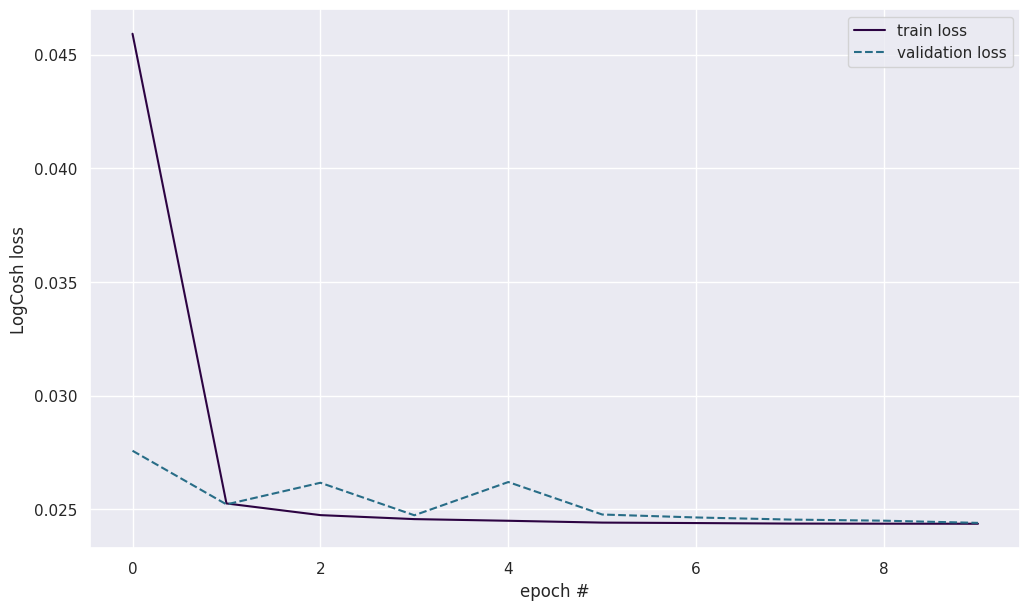

In [ ]:
# plot parameters
plt.figure(figsize=(12,7))
colors = ['#2c0342', '#223167', '#286d87', '#4fb49d', '#9af486']
#labels = [r'$x_0 = $' + str(x0) for x0 in x0_arr]

# plot training history and validation scores
plt.plot(history.history['loss'], color=colors[0],
         label='train loss')
plt.plot(history.history['val_loss'], color=colors[2], linestyle='--',
         label='validation loss')
plt.legend()
plt.xlabel('epoch #')
plt.ylabel('LogCosh loss')
plt.show()

In [ ]:
# make prediction
y_pred = net.predict(x_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 34s 34s/step


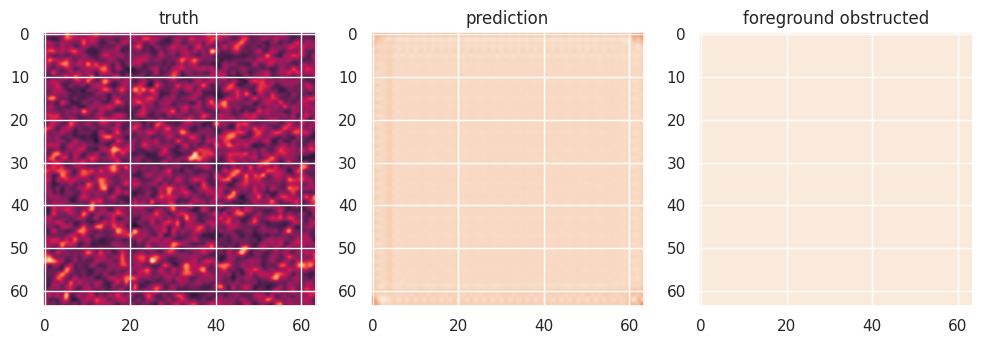

In [ ]:
xval_c1 = np.squeeze(x_test)[5].T #foreground obstructed test
yval_c1 = np.squeeze(y_test)[5].T #cosmological signal truth test
y_c1_pred = np.squeeze(y_pred)[5].T # cosmological signal prediction


fig, ax = plt.subplots(figsize=(12,24), ncols=3, nrows=1)
ax[0].imshow(yval_c1[0], vmin=0, rasterized=True,
                  interpolation='spline16')
ax[0].set_title('truth')
ax[1].imshow(y_c1_pred[0], vmin=-1, rasterized=True,
                  interpolation='spline16')
ax[1].set_title('prediction')
ax[2].imshow(xval_c1[0], vmin=-1, rasterized=True,
                  interpolation='spline16')
ax[2].set_title('foreground obstructed')

plt.show()